# RegNetY models with TensorFlow 2

In this notebook, we will load the pretrained checkpoints for RegNetY models from TFHub and fine tune them on new, unseen data. We will use these checkpoints to classify images from the `tf-flowers` dataset from [tfds](https://www.tensorflow.org/datasets/catalog/tf_flowers).

These models were pre-trained on the ImageNet-1k dataset. You can find the implementation of these models in this [repository](https://github.com/AdityaKane2001/regnety). You can learn more about RegNets in this [paper](https://arxiv.org/abs/2003.13678).

We have four variants of RegNetY available to choose from:
- 200MF
- 400MF
- 600MF
- 800MF   

(MF: Million Floating point operations)   

These are arranged in increasing order of complexity. You can choose whichever model suits your needs.


## Imports

In [1]:
%%capture
#!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import json
import numpy as np
import os
%matplotlib inline
import time
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import pathlib
import math
#tfds.disable_progress_bar()
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Helper functions

In [3]:
%%capture

!wget -O labels.json https://raw.githubusercontent.com/AdityaKane2001/regnety/main/regnety/config/imagenet_synset_to_human.json 

def get_synset_labels(filepath: str) -> dict:
    with open(filepath, "r") as f:
        raw_labels_dict = json.load(f)
    labels_dict = dict()

    for i in raw_labels_dict:
        labels_dict[int(i)] = (
            raw_labels_dict[i]["id"],
            raw_labels_dict[i]["label"],
        )
    return labels_dict

def get_human_label(model_output):
    labels_dict = get_synset_labels("./labels.json")
    softmax = tf.nn.softmax(model_output)
    softmax = tf.reshape(softmax, (1000,))
    label_int = tf.math.argmax(softmax, axis=0).numpy()
    label, synset = labels_dict[label_int]
    return label, synset

def get_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = np.array(image)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, (1, image.shape[0],image.shape[1],3))
    return image

def plot_image_with_prediction(image, model_output):
    reshaped_image = np.reshape(image.numpy(), (image.shape[1], image.shape[2], 3))
    reshaped_image = reshaped_image / 255.
    _, human_label = get_human_label(model_output)
    plt.axis("off")
    plt.title(human_label ,
          fontsize='20', pad=10)
    plt.imshow(reshaped_image)
    
def plot_image_with_label(image, label):
    plt.axis("off")
    plt.title(label ,
              fontsize='20', pad=10)
    plt.imshow(image)

def visualize_samples_tf_flowers(ds):
    f, plots = plt.subplots(3,3,figsize=(10,10))
    label_dict = dict({
        0: "dandelion",
        1: "daisy",
        2: "tulips",
        3: "sunflowers",
        4: "roses"
    })
    images = []
    labels = []

    for sample in ds:
        if len(labels)>9:
            break
        images.append(sample[0])
        labels.append(label_dict[sample[1].numpy()])
    
    for i in range(3):
        for j in range(3):
            plots[i, j].imshow(images[i*3 + j])
            plots[i, j].set_title(labels[i*3 + j])
            plots[i, j].axis('off')
    
    plt.show()

def visualize_preprocessed_samples_tf_flowers(ds):
    f, plots = plt.subplots(3,3,figsize=(10,10))
    label_dict = dict({
        0: "dandelion",
        1: "daisy",
        2: "tulips",
        3: "sunflowers",
        4: "roses"
    })
    images = []
    labels = []

    for sample in ds:
        if len(labels)>9:
            break
        images.append(sample[0] / 255. )
        labels.append(label_dict[np.argmax(sample[1].numpy())])
    
    for i in range(3):
        for j in range(3):
            plots[i, j].imshow(images[i*3 + j])
            plots[i, j].set_title(labels[i*3 + j])
            plots[i, j].axis('off')
    
    plt.show()


# Out-of-the-box inference

RegNetY is trained on ImageNet1k. You can directly get predictions for your images *without any* preprocessing. Simple, right?

## Loading checkpoints from TFHub

TF Hub is the defacto method to load pretrained models. Here's how you can load a pretrained RegNetY checkpoint from TFHub. For this tutorial, we will be using RegNetY 400MF.


The resulting model works just like any other `keras.Model`, you can call `fit()`, `predict()`, `evaluate()` as you would do with any other model.

Note that the `base_layer` object outputs logits, and not actual probabilities of classes. This is done for numerical stability.

In [3]:
base_layer = hub.load("https://tfhub.dev/adityakane2001/regnety400mf_classification/1")

2022-05-06 02:58:23.235632: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 02:58:27.750482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19339 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2022-05-06 02:58:27.752740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19339 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:1e:00.0, compute capability: 8.6
2022-05-06 02:58:27.754597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

## Create and run the model on an image 

Here we instantiate the model and get predictions for an image. You can see that the model was successfully able to determine that the image is indeed of an owl.

The image used is [CC0 licensed](https://creativecommons.org/publicdomain/zero/1.0/legalcode).

2022-05-06 02:58:34.675016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-06 02:58:36.381852: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


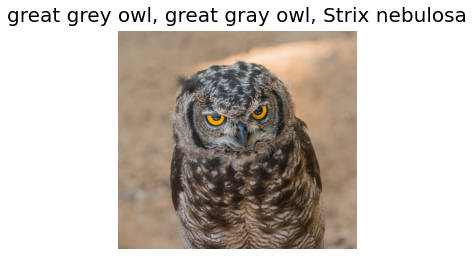

In [4]:
image = get_image("https://images.pexels.com/photos/6474755/pexels-photo-6474755.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260")

predictions = base_layer(image)

plot_image_with_prediction(image, predictions)

# Fine-tuning RegNetY

Fine-tuning RegNetY is as simple as it is with any other Keras model. There are mainly two things we need to take care of:
1. Preprocessing
2. Modifying model architecture to change the `Head` of the model. This is only applicable if you use the classifier model. If you use the feature vector models, they don't have the `Head` layers. Thus, you can directly attach  `GlobalAveragePooling2D` and `Dense` layers at the end.


## Preprocessing for RegNetY

All variants of RegNetY use the same preprocessing. In the following cell, we create an input pipeline consisting of only the bare minimum preprocessing required for RegNetY.   

Note that unlike most models on TFHub, RegNetY has its resizing, rescaling and normalization layers _inside_ the model. This way, it can take advantage of the processing power of GPUs and TPUs.
   
This makes our life easier. We don't have to worry about preprocessing overhead caused due to rescaling and resizing. We just need to make sure that the input images have pixel values in the range `[0, 255]`. 

In this example, we are adding a couple of augmentations to make our model more robust.

In [4]:
CROP_SIZE = 224
NUM_CLASSES = 5
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

def preprocess_train(images, labels):
    aug_images = tf.image.resize(images, (320, 320))
    aug_images = tf.image.random_flip_left_right(aug_images)
    aug_images = tf.image.random_crop(aug_images, size=(CROP_SIZE, CROP_SIZE, 3))

    one_hot_labels = tf.cast(labels, tf.uint8) # convert label type to uint8
    one_hot_labels = tf.one_hot(one_hot_labels, depth=NUM_CLASSES) # convert label to one hot
    return aug_images, one_hot_labels

def preprocess_val(images, labels):
    aug_images = tf.image.resize(images, (256, 256))
    aug_images = tf.image.central_crop(aug_images, 224./256.) # The input should be 224 finally

    one_hot_labels = tf.cast(labels, tf.uint8)
    one_hot_labels = tf.one_hot(one_hot_labels, depth=NUM_CLASSES)
    return aug_images, one_hot_labels


## Load data from TensorFlow Datasets

For this tutorial, we are going to fine-tune on [`tf_flowers`](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/).

It contains 3,670 images of flowers over 5 classes. It is perfect for quick experimentation and fine-tuning. 

Here we load the dataset and visualize some samples from the dataset.

2022-05-06 04:11:48.741287: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 04:11:53.230412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19339 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2022-05-06 04:11:53.232588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19339 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:1e:00.0, compute capability: 8.6
2022-05-06 04:11:53.234414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

Raw data


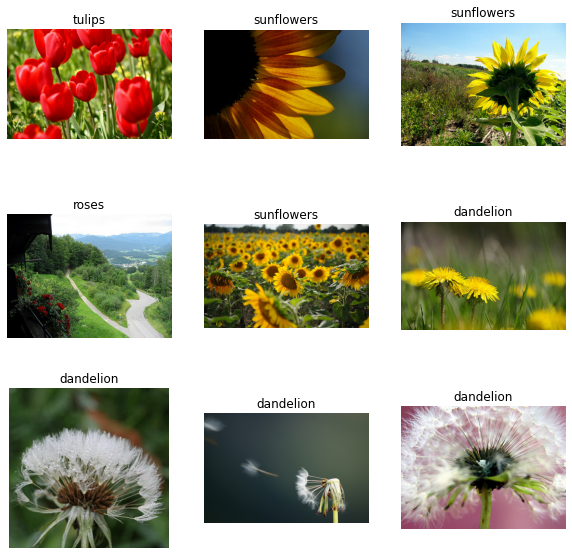

In [5]:
train_ds, val_ds, test_ds = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=False,
    shuffle_files=True,
    as_supervised=True,
) 

print("Raw data")

visualize_samples_tf_flowers(train_ds)


Finally, we batch and map the train dataset to the `preprocess` function we defined earlier. For simplicity, we do not augment the validation and test data.  

Now the data is ready to be used for training.

In [6]:
train_ds = train_ds.map(preprocess_train, num_parallel_calls=AUTO)
val_ds = val_ds.map(preprocess_val, num_parallel_calls=AUTO)
test_ds = test_ds.map(preprocess_val, num_parallel_calls=AUTO)

print("Augmented data")

# visualize_preprocessed_samples_tf_flowers(train_ds)

train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
for batch in train_ds:
    print(batch[0].shape)
    break

Augmented data
(128, 224, 224, 3)


## Make the model for fine-tuning

Here we add a custom head to the model. This way, we can classify our flowers dataset. Here, we have specified `trainable=True`, which will allow us to fine-tune the network. In case one wants to use the feature vectors directly without fine-tuning, we specify `trainable=False`




In [7]:
def make_model(base_model, num_classes):
    finetuning_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((224, 224, 3)),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes)
    ])
    return finetuning_model

base_layer = hub.KerasLayer("/home/naibo/exps/model-search/models/tf-dev/feature-extractor/regnety400mf_feature_extractor_1", trainable=True) ##True means to finetune!!!

model = make_model(base_layer, 5)


model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 7, 7, 440)         3617881   
                                                                 
 global_average_pooling2d (G  (None, 440)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2205      
                                                                 
Total params: 3,620,086
Trainable params: 3,596,671
Non-trainable params: 23,415
_________________________________________________________________


## Train and evaluate the model

Here we compile the model with the settings of our choice. Then we train the model for 20 epochs. We will finally evaluate the model on unseen data.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]    
)

print("Training model")
model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)
print("Evaluating model")
eval_loss, eval_acc = model.evaluate(
    test_ds
)

print("Evaluation accuracy is ", eval_acc)

Training model
Epoch 1/10


2022-05-06 04:12:12.390217: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: sequential/keras_layer/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/Stage_3/StatefulPartitionedCall/Stage_3_YBlock_5/Stage_3_YBlock_5_bn1x1_2/cond/branch_executed/_7621
2022-05-06 04:12:14.838200: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-06 04:12:17.061781: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


22/22 [==============================] - 17s 186ms/step - loss: 1.1544 - accuracy: 0.5746 - val_loss: 0.5397 - val_accuracy: 0.8203
Epoch 2/10


2022-05-06 04:12:21.929505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 3s 153ms/step - loss: 0.4087 - accuracy: 0.8679 - val_loss: 0.3679 - val_accuracy: 0.8750
Epoch 3/10


2022-05-06 04:12:25.440296: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 3s 153ms/step - loss: 0.2607 - accuracy: 0.9215 - val_loss: 0.3060 - val_accuracy: 0.8984
Epoch 4/10


2022-05-06 04:12:28.933209: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 3s 147ms/step - loss: 0.1913 - accuracy: 0.9453 - val_loss: 0.2722 - val_accuracy: 0.9023
Epoch 5/10


2022-05-06 04:12:32.333358: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 4s 164ms/step - loss: 0.1464 - accuracy: 0.9620 - val_loss: 0.2482 - val_accuracy: 0.9062
Epoch 6/10


2022-05-06 04:12:36.054326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 3s 147ms/step - loss: 0.1120 - accuracy: 0.9719 - val_loss: 0.2359 - val_accuracy: 0.9102
Epoch 7/10


2022-05-06 04:12:39.411376: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


22/22 [==============================] - 3s 144ms/step - loss: 0.0902 - accuracy: 0.9808 - val_loss: 0.2297 - val_accuracy: 0.9062
Epoch 8/10
22/22 [==============================] - 3s 144ms/step - loss: 0.0730 - accuracy: 0.9837 - val_loss: 0.2140 - val_accuracy: 0.9102
Epoch 9/10
22/22 [==============================] - 3s 144ms/step - loss: 0.0558 - accuracy: 0.9915 - val_loss: 0.2102 - val_accuracy: 0.9180
Epoch 10/10
22/22 [==============================] - 3s 144ms/step - loss: 0.0461 - accuracy: 0.9933 - val_loss: 0.2032 - val_accuracy: 0.9180
Evaluating model
2/2 [==============================] - 0s 98ms/step - loss: 0.1440 - accuracy: 0.9453
Evaluation accuracy is  0.9453125


2022-05-06 04:12:52.884526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
eval_loss, eval_acc = model.evaluate(
    train_ds
)

print("Evaluation accuracy is ", eval_acc)

22/22 [==============================] - 1s 46ms/step - loss: 0.0330 - accuracy: 0.9961
Evaluation accuracy is  0.99609375


For illustration purposes, we have used a rudimentary setup. But with good input pipeline and hyperparameter tuning one can easily achieve phenomenal results using RegNetY. You can learn more about transfer learning [here](https://keras.io/guides/transfer_learning/). More about hyperparameter tuning [here](https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html). It is important to note that BiT Hyperrule is a heuristics based approach, which means most of the simple rules may directly apply to the downstream tasks. However, it is completely heuristics based (i.e. based on intuition) and thus is not guranteed to show elevated performance on *all* tasks.

## Save model for further use

In [15]:
model.save("regnety")

2022-05-04 23:59:00.276710: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: regnety/assets


Your model is now ready to use. You can easily load this model as you would do with any other Keras model. For more information on saving and loading, see this [tutorial](https://www.tensorflow.org/guide/keras/save_and_serialize) by TensorFlow.

# Summary



Hope you found this tutorial useful. To summarize, this tutorial demonstrates how to load a pretrained RegNetY model and use it for out-of-box inference. We also saw how to fine-tune the models to train on custom data. 

If you face any issue with this notebook or want to know more about the implementation, please feel free to drop an issue [here](https://github.com/AdityaKane2001/regnety/issues).

Thank you and happy learning!